In [ ]:
'''
file for the pipeline
Tfidf + clip -> Lightgbm
'''
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from lightgbm import LGBMRegressor, plot_importance
import gc
import matplotlib.pyplot as plt
from model_data import SMAPELoss

In [11]:
train_data = pd.read_csv('student_resource/dataset/train_focused_2.csv', usecols=['sample_id', 'focused_sentence', 'value', 'unit'])
train_data = pd.concat([train_data, pd.read_csv('train_clip_embed.csv')], axis=1)
train_data

,sample_id,focused_sentence,value,unit,0,1,2,3,4,5,...,2039,2040,2041,2042,2043,2044,2045,2046,2047,prices
0,33127,"Item Name: La Victoria Green Taco Sauce Mild, ...",72.00,fluid ounce,0.174020,-0.143133,-0.242676,-0.533552,0.782315,1.973485,...,-0.125172,0.848946,-1.164739,0.025560,0.019596,0.232899,-0.708067,1.323833,0.778812,1.773256
1,198967,"Item Name: Salerno Cookies, The Original Butte...",32.00,ounce,-1.044623,-0.257172,-0.450125,-1.454822,1.349169,2.260221,...,-0.531549,0.408175,-1.389376,-0.290974,0.272160,0.055910,-0.909074,1.379296,0.838086,2.647592
2,261251,"Item Name: Bear Creek Hearty Soup Bowl, Creamy...",11.40,ounce,0.572620,0.231423,-0.665190,-0.891879,0.521890,0.779511,...,-0.253824,1.169248,-1.005889,-0.050430,0.145862,0.427845,-0.818516,1.431625,0.829270,1.088562
3,55858,Item Name: Judee’s Blue Cheese Powder 11.25 oz...,11.25,ounce,-1.323858,1.099959,-1.524922,-0.707894,1.355102,2.585816,...,-0.392438,0.868274,-1.389667,-0.025847,0.299311,0.401773,-1.306074,1.137081,1.183864,3.444895
4,292686,"Item Name: kedem Sherry Cooking Wine, 12.7 Oun...",12.00,count,-1.899729,0.210678,-0.451701,-0.719948,1.165255,2.497567,...,-0.530559,-0.226734,-0.724770,-1.245805,-0.022336,-0.252454,-1.618746,1.719296,1.287198,4.211979
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73494,41424,Item Name: ICE BREAKERS Spearmint Sugar Free M...,12.00,ounce,-0.286374,-0.026122,-0.200137,-1.203589,0.714462,2.499844,...,0.185565,0.700063,-1.352082,-0.212757,0.769293,0.384514,-0.725251,1.150429,0.713589,2.433175
73495,35537,"Item Name: Davidson's Organics, Vanilla Essenc...",100.00,count,-0.585787,0.073715,-0.874126,-1.200201,2.033060,3.064392,...,0.093100,0.093576,-1.410029,-0.788220,0.549250,-0.229552,-1.898382,1.652964,1.233520,3.608753
73496,249971,Item Name: Jolly Rancher Hard Candy - Blue Ras...,80.00,ounce,-1.785327,0.563642,-1.434347,-0.473331,0.938413,1.910999,...,-0.251237,-0.289186,-1.198056,-0.917872,0.270541,-0.197851,-1.708235,2.349185,0.912569,3.938275
73497,188322,Item Name: Nescafe Dolce Gusto Capsules - CARA...,16.00,count,-1.577085,0.323915,-1.138542,-0.754939,0.970459,2.210608,...,-0.216122,0.904127,-1.460592,-0.403156,0.507181,0.181354,-0.710278,0.913180,0.909285,2.789630


In [3]:
gc.collect()

10

In [4]:
X_train, y_train = train_data.drop('prices', axis=1), train_data['prices'].copy()
del train_data
gc.collect()

0

In [5]:

def logcosh_objective(y_true, y_pred):
    """
    This function calculates the gradient and hessian for the log-cosh loss.
    This is what LightGBM does behind the scenes when you use 'logcosh'.
    """
    # The gradient is the first derivative of the loss function.
    # It tells the model the direction and magnitude of the error.
    grad = np.tanh(y_pred - y_true)

    # The hessian is the second derivative of the loss function.
    # It informs the model about the curvature of the loss, helping it
    # take more optimal steps during training.
    hess = 1.0 - grad**2
    return grad, hess


def logcosh_eval(y_true, y_predict):
    return [('logcosh_metric', np.log(np.cosh(y_predict-y_true)).mean(), False)]  
    

In [6]:
text_transform = Pipeline([('vectorizer', TfidfVectorizer(max_features=8000, ngram_range=(1, 2))),
                           ('dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True))])

ct_transform = ColumnTransformer([('text_transform', text_transform, 'focused_sentence')],
                                remainder = 'passthrough')

pipeline = Pipeline([('transform', ct_transform),
                     ('lgbm', LGBMRegressor(objective='regression_l1',
                                            metric='rmse',
                                            n_estimators=2000,
                                            learning_rate=0.01,
                                            num_leaves=31,
                                            # max_depth=8,
                                            min_child_samples=20,
                                            subsample=0.8,
                                            colsample_bytree=0.8,
                                            random_state=42,
                                            n_jobs=-1,
                                            device_type='gpu'))])

In [7]:
pipeline.fit(X_train, y_train)

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1726240
[LightGBM] [Info] Number of data points in the train set: 73499, number of used features: 10048
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080 Ti, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 2067 dense feature groups (144.95 MB) transferred to GPU in 0.060410 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 2.704711


,steps,"[('transform', ...), ('lgbm', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('text_transform', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


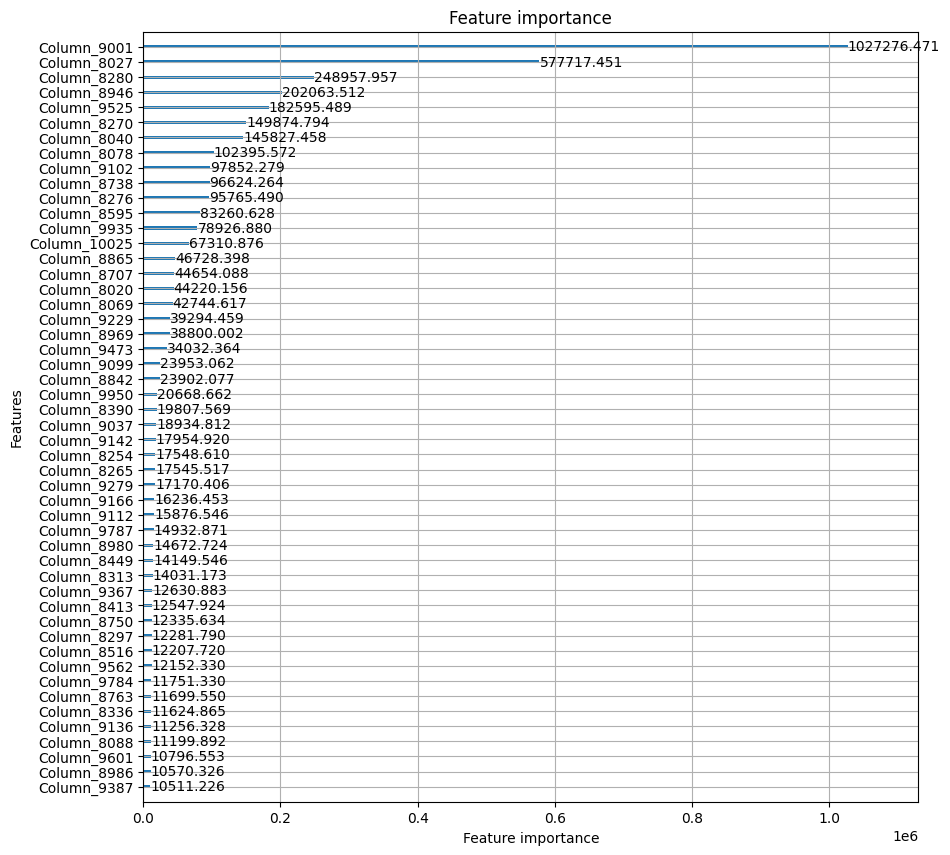

In [28]:
ax = plot_importance(pipeline[-1], importance_type='gain', max_num_features=50)
ax.get_figure().set_size_inches(10, 10)

In [8]:
y_preds = pipeline.predict(X_train)

C:\Users\DCL USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


(array([30001., 21900.,  9956.,  5130.,  2686.,  1775.,  1001.,   667.,
          322.,    61.]),
 array([  0.73306484,  11.08763502,  21.44220519,  31.79677537,
         42.15134555,  52.50591572,  62.8604859 ,  73.21505608,
         83.56962625,  93.92419643, 104.27876661]),
 <BarContainer object of 10 artists>)

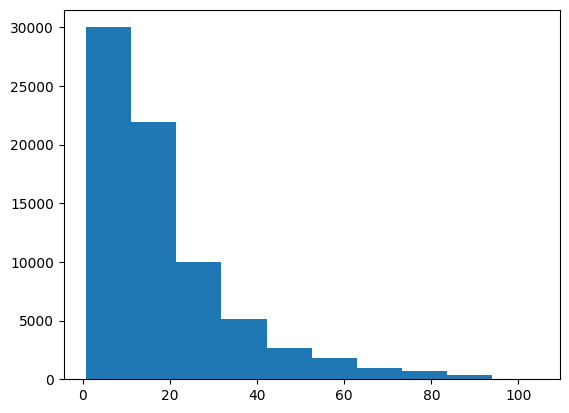

In [10]:
plt.hist(np.expm1(y_preds))

In [12]:
test_data = pd.read_csv('student_resource/dataset/test_focused.csv', usecols=['focused_sentence'])
test_data = pd.concat([test_data, pd.read_csv('test_clip_embed.csv')], axis=1)
test_data.head()

,focused_sentence,0,1,2,3,4,5,6,7,8,...,2039,2040,2041,2042,2043,2044,2045,2046,2047,prices
0,Item Name: Rani 14-Spice Eshamaya's Mango Chut...,-1.348760,0.321930,-1.185519,-1.311213,2.139934,1.840348,2.206761,1.284696,0.920878,...,-0.162835,0.537928,-1.464591,-0.306322,1.110158,-0.007308,-1.558966,1.406268,0.887152,0.0
1,Item Name: Natural MILK TEA Flavoring extract ...,-1.027735,0.954196,-1.551497,-1.714152,1.232652,1.918990,2.447417,1.904164,0.606909,...,-0.045907,0.837247,-1.404851,0.123945,1.152840,0.325667,-0.736876,0.973377,0.994311,0.0
2,Item Name: Honey Filled Hard Candy - Bulk Pack...,-0.955755,-0.640269,-1.076678,0.978837,0.541126,1.586140,2.662478,2.379204,0.993017,...,-0.414731,0.505255,-1.105734,-0.891332,0.667471,0.047161,-1.489766,1.431225,0.953298,0.0
3,Item Name: Vlasic Snack'mm's Kosher Dill 16 Oz...,0.151534,0.322207,-1.154273,-0.352811,0.178547,0.760418,1.133446,-0.243930,0.610778,...,-0.376377,0.916929,-1.099116,-0.982928,0.318741,0.430117,-1.190900,1.347082,1.114862,0.0
4,"Item Name: McCormick Culinary Vanilla Extract,...",-0.934557,0.206794,-1.458136,-1.488192,0.629494,1.955989,2.185993,0.941259,1.750161,...,-0.303363,0.933871,-1.380360,0.081186,0.506748,0.212650,-1.234667,1.046096,1.404367,0.0


In [13]:
X_test = test_data.drop('prices', axis=1)
del test_data
gc.collect()

51

In [14]:
y_preds_test = pipeline.predict(X_test)

C:\Users\DCL USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


(array([3.2806e+04, 2.3627e+04, 9.3460e+03, 4.0830e+03, 2.1600e+03,
        1.3370e+03, 8.5600e+02, 5.9200e+02, 1.9000e+02, 3.0000e+00]),
 array([  0.96104656,  12.30206009,  23.64307362,  34.98408715,
         46.32510067,  57.6661142 ,  69.00712773,  80.34814126,
         91.68915478, 103.03016831, 114.37118184]),
 <BarContainer object of 10 artists>)

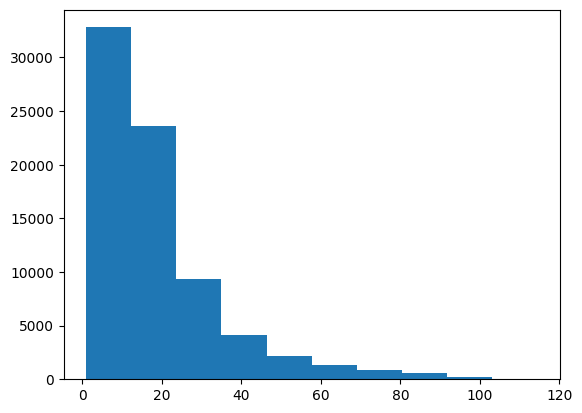

In [15]:
plt.hist(np.expm1(y_preds_test))

{'whiskers': [<matplotlib.lines.Line2D at 0x25bea0e4fd0>,
 'caps': [<matplotlib.lines.Line2D at 0x25bea0e55d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x25bea0e4df0>],
 'medians': [<matplotlib.lines.Line2D at 0x25bea0e5bd0>],
 'fliers': [<matplotlib.lines.Line2D at 0x25bea0e5ed0>],
 'means': []}

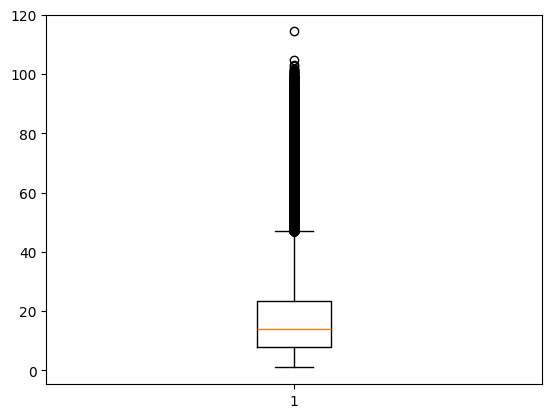

In [18]:
plt.boxplot(np.expm1(y_preds_test))

In [20]:
test_sub = pd.read_csv('student_resource/dataset/test_focused.csv', usecols=['sample_id'])
test_sub['price'] = np.expm1(y_preds_test)
test_sub

,sample_id,price
0,100179,18.109054
1,245611,13.868414
2,146263,17.252804
3,95658,3.362179
4,36806,14.759040
...,...,...
74995,93616,6.121987
74996,249434,10.591680
74997,162217,2.246149
74998,230487,9.207911


In [21]:
test_sub.to_csv('sub4.csv', index=False)

In [26]:
pipeline[0].transform(X_train).sh

array([[ 0.        ,  0.        ,  0.        , ..., -0.70806706,
         1.3238331 ,  0.7788123 ],
       [ 0.        ,  0.        ,  0.        , ..., -0.9090742 ,
         1.3792961 ,  0.8380863 ],
       [ 0.        ,  0.        ,  0.        , ..., -0.8185165 ,
         1.4316255 ,  0.82927006],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., -1.7082353 ,
         2.3491852 ,  0.9125685 ],
       [ 0.        ,  0.        ,  0.        , ..., -0.7102782 ,
         0.91318035,  0.9092855 ],
       [ 0.        ,  0.        ,  0.        , ..., -0.1658516 ,
         0.5730438 ,  0.15207833]])